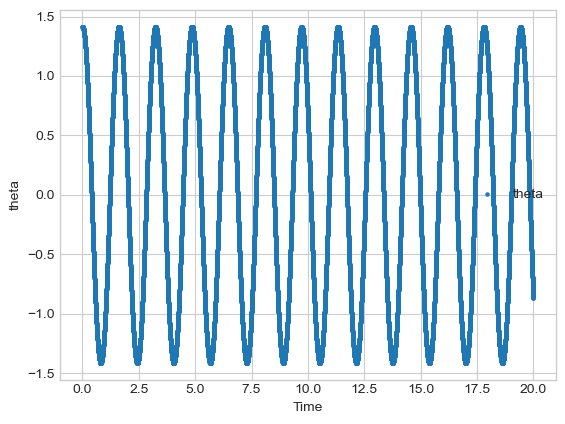

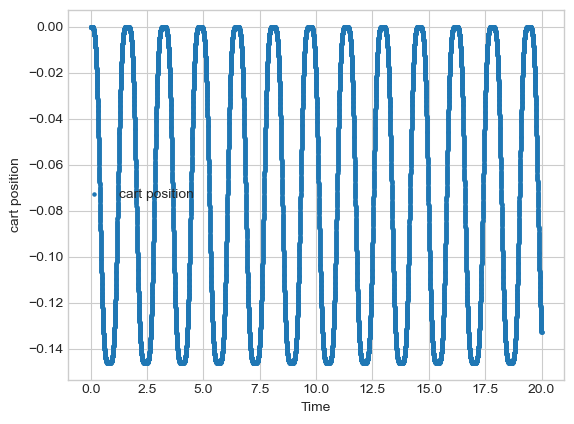

In [2]:
import numpy as np

def equations(state, t, F, m, ell, M, g, dot_y, dot_z):
    # ddot_x = (F + m * ell * ddot_theta * np.cos(theta) - m * ell * (dot_theta)**2 * np.sin(theta)) / (M + m)
    # ddot_theta = (g * np.sin(ddot_theta) + ddot_x * np.cos(theta)) / ell
    x, theta, y, z = state

    dxdt = y
    dydt = (F + m * ell * dot_z * np.cos(theta) - m * ell * z**2 * np.sin(theta)) / (M + m)
    dthetadt = z
    dzdt = (dot_y * np.cos(theta) + g * np.sin(theta)) / ell

    return np.array([dxdt, dthetadt, dydt, dzdt])#dxdt, dydt, dthetadt, dzdt


def explicit_euler(f_0, t_max, dt, F, m, ell, M, g, dot_y, dot_z):
    t_values = np.arange(0, t_max, dt)
    f_values = [f_0]

    for i in range(1, len(t_values)):
        t_i = t_values[i-1]
        f_i = f_values[i - 1]
        f_new = f_i + dt * equations(f_i, t_i, F, m, ell, M, g, dot_y, dot_z)
        f_values.append(f_new)

    return t_values, f_values

def runge_kutta_fourth_order(f_0, dt, t_max, F, m, ell, M, g, dot_y, dot_z):
    t_values = np.arange(0, t_max, dt)
    f_values = [f_0]

    for i in range(1, len(t_values)):
        t_i = t_values[i-1]
        f_i = f_values[i - 1]

        k1 = equations(f_i, t_i, F, m, ell, M, g, dot_y, dot_z)
        k2 = equations(f_i + 0.5 * k1 * dt, t_i + 0.5 * dt, F, m, ell, M, g, dot_y, dot_z)
        k3 = equations(f_i + 0.5 * k2 * dt, t_i + 0.5 * dt,F, m, ell, M, g, dot_y, dot_z)
        k4 = equations(f_i + k3 * dt, t_i + dt, F, m, ell, M, g, dot_y, dot_z)

        f_new = f_i + (1 / 6) * (k1 + 2 * k2 + 2 * k3 + k4) * dt
        f_values.append(f_new)

    return t_values, f_values

theta = 0.9 * np.pi/2

initial_state = np.array([0,theta,0,0])
t_max = 20
dt = 0.001
F = 0
m = 2
ell = 0.5
M = 5
g = -9.81

dot_y = 0
dot_z = 0


#t_values, f_values = explicit_euler(initial_state, t_max, dt, F, m, ell, M, g, dot_y, dot_z)
t_values, f_values = runge_kutta_fourth_order(initial_state, dt, t_max, F, m, ell, M, g, dot_y, dot_z)

import matplotlib.pyplot as plt

# theta = np.reshape(f_values, (np.shape(f_values)[0], np.shape(f_values)[1])) [1]
theta_values = []
for f in f_values:
    theta_values.append(f[1])
    

#plt.scatter(t_values, np.reshape(f_values, (np.shape(f_values)[1], np.shape(f_values)[0]))[1])
plt.scatter(t_values, theta_values, label = 'theta', s = 5)

plt.xlabel('Time')
plt.ylabel('theta')
plt.legend()

plt.show()


cart_pos = []
for f in f_values:
    cart_pos.append(f[0])

plt.scatter(t_values, cart_pos, s = 5, label = 'cart position')

plt.xlabel('Time')
plt.ylabel('cart position')
plt.legend()

plt.show()


An inverted pendulum is a pendulum that sits on a cart, which can be moved with a force. It follows the following equations of motion

$$(M+m)\ddot{x} - m\ell\ddot{\theta} \cos \theta + m\ell\dot{\theta}^2 \sin \theta = F,$$
$$\ell \ddot{\theta} - g \sin \theta = \ddot{x} \cos \theta$$

Here $x$ is the position of the cart, $\theta$ is the angle of the pendulum, $\ell$ is the length of the pendulum, and $M$, $m$ are the mass of the cart and the pendulum, respectively.

Finally, is the force applied to the cart, this force can be time-dependent.

1. Write an accurate simulation of the above system to solve for $x(t)$ and $\theta(t)$ and make a nice visualization of the simulation.
2. By applying a time-varying force that depends on the state parameters, e.g. $F(x(t),\dot{x}(t),\theta(t),\dot{\theta}(t))$, can you balance the pendulum upright (assuming it starts upright). It could make sense to consider requirements on $x$ as well to ensure the pendulum stays within a reasonable position.
3. Play with the parameters, is it easier to balance a long pendulum? A heavy one? How do you measure this?
4. If the pendulum starts hanging, can you get it upright by the applying the correct force? Can you do in a way so it works for all lengths and masses?

Finally, if you have time, expand your simulation to a double pendulum and go through the above questions again.

$$\frac{dx}{dt} = y$$
$$\frac{dy}{dt} = \frac{F + m \cdot \ell \cdot \dot{z} \cdot \cos (\theta) - m \cdot \ell \cdot z^2 \cdot \sin (\theta)}{M + m}$$

$$\frac{d\theta}{dt} = z$$
$$\frac{dz}{dt} = \frac{\dot{y}\cdot \cos(\theta) + g \cdot \sin(\theta)}{\ell}$$


In [5]:
import numpy as np
from numpy import sin, cos, pi

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.patches import Rectangle
plt.style.use('seaborn-whitegrid')

def render(t_values, f_values):
    cart_position_values = [f[0] for f in f_values]
    theta_values = [f[1] for f in f_values] #a_solution
    skip_frames = 40

    print("HELLO")
    cart_position_values = cart_position_values[::skip_frames]
    theta_values = theta_values[::skip_frames]

    frames = len(cart_position_values)

    ell = 0.5
    j1_x = ell * sin(theta_values) + cart_position_values
    j1_y = ell * cos(theta_values)

    fig = plt.figure()
    ax = fig.add_subplot(111, autoscale_on=False, xlim=(-1, 1), ylim=(-1, 1))
    ax.set_aspect('equal')
    ax.grid()

    patch = ax.add_patch(Rectangle((0, 0), 0, 0, linewidth=1, edgecolor='k', facecolor='r'))

    line, = ax.plot([], [], 'o-', lw=2)
    time_template = 'time: %.1f s'
    time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

    cart_width = 0.15
    cart_height = 0.1

    def init():
        print("init")
        line.set_data([], [])
        time_text.set_text('')
        patch.set_xy((-cart_width / 2, -cart_height / 2))
        patch.set_width(cart_width)
        patch.set_height(cart_height)
        return line, time_text


    def animate(i):
        thisx = [cart_position_values[i], j1_x[i]]
        thisy = [0, j1_y[i]]

        line.set_data(thisx, thisy)
        now = i * skip_frames * dt
        time_text.set_text(time_template % now)

        patch.set_x(cart_position_values[i] - cart_width / 2)
        return line, time_text, patch

    ani = animation.FuncAnimation(fig, animate, frames=frames,
                                  interval=1, blit=True, init_func=init)
    plt.close(fig)
    return ani
    
ani = render(t_values, f_values)
%time ani.save('free_dipc.gif', writer='imagemagick', fps=24)



/tmp/ipykernel_11321/1365891836.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')
MovieWriter imagemagick unavailable; using Pillow instead.


HELLO
init
init
init
CPU times: user 38.7 s, sys: 1.89 s, total: 40.6 s
Wall time: 40.6 s
